In [1]:
%matplotlib inline

import os.path as path
import stripy as stripack
import numpy as np

import pyproj

import cartopy
import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colorbar as colorbar

In [2]:
def spherical_midpoints(interpolator):

    import pyproj
    
    lst = interpolator.lst
    lend = interpolator.lend
    lptr = interpolator.lptr

    g = pyproj.Geod(ellps='WGS84')

    midlon_array = np.ones((len(lptr))) * -99999.0
    midlat_array = np.ones((len(lptr))) * -99999.0
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats


    for i in range(0,len(lptr),1):
        n1 = lst[i]-1
        n2 = lst[lptr[i]-1]-1
        if n1 < n2:
            midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
            midlon_array[i] = midlonlat[0]
            midlat_array[i] = midlonlat[1]
            
    valid_points =  np.where(midlon_array != -99999.0 )    

    midlon_array = midlon_array[valid_points[0]]
    midlat_array = midlat_array[valid_points[0]]
    
   
    return midlon_array, midlat_array


def subdivide_triangle(tri, interpolator):
    """
    Add midpoints to sides of triangle tri={n1, n2, n3}
    """
    
    import pyproj
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    # Easiest is to do this by hand, I think
    
    (n1, n2, n3) = tri

    midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n2],latv1[n2],lonv1[n3],latv1[n3], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n3],latv1[n3],lonv1[n1],latv1[n1], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    return np.array(midlon), np.array(midlat)


def subdivide_triangle_list(tlist, interpolator):
    
    segments = []
    
    ntri, tris = interpolator.tri_list()
   
    for i in range(0, len(tlist)):   
        (n1, n2, n3) = tris[i]
                  
        segments.append( min((n1,n2), (n2, n1)))
        segments.append( min((n3,n2), (n2, n3)))
        segments.append( min((n3,n1), (n1, n3)))
       
    segList = sorted(list(set(segments)))
        
    new_nodes = split_segments(segList, interpolator)
        
    return new_nodes
   

def subdivide_node_list(nodes_to_refine, interpolator):
    
    segments = []

    for node in nodes_to_refine:
        neighbours = node_neighbours(node, interpolator)
    
        for n1 in neighbours:
            segments.append( min( tuple((node, n1)), tuple((n1, node))) )

    # Unique entries only
    
    
    segList = sorted(list(set(segments)))
        
    new_nodes = split_segments(segList, interpolator)
    
    return new_nodes
    
                                      

def add_spherical_midpoints(interpolator):   
    
    midlon_array, midlat_array = spherical_midpoints(interpolator)
    
    lonv2 = np.concatenate((interpolator.lons, midlon_array), axis=0)
    latv2 = np.concatenate((interpolator.lats, midlat_array), axis=0)
    
    return np.degrees(lonv2), np.degrees(latv2)
    

def node_neighbours(node, interpolator):
    
    lpl = interpolator.lend[node-1]
    lp = lpl
    k = 1

    neighbours = []

    while True:
        lp = interpolator.lptr[lp-1]
        neighbours.append(interpolator.lst[lp-1])
        if (lp == lpl):
            break
        k += 1

    return neighbours
 
    
    
def split_segments(segList, interpolator):  
    
    import pyproj 
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    for segment in segList:
    
        n1 = segment[0]-1
        n2 = segment[1]-1
    
        midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )

        midlon.append(midlonlat[0])
        midlat.append(midlonlat[1])

    
    return np.array(midlon), np.array(midlat)


# hfgrid, hfnorm, hfcount  = weighted_average_to_nodes(lons, lats, fakeflux, interpolator )

def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid  = np.zeros(interpolator.npts)
    norm  = np.zeros(interpolator.npts)
    count  = np.zeros(interpolator.npts)

    bcc, nodes = interpolator.find_point(np.radians(lons), np.radians(lats))

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]-1] += bcc[i][0] * data[i]
        grid[nodes[i][1]-1] += bcc[i][1] * data[i]
        grid[nodes[i][2]-1] += bcc[i][2] * data[i]

        norm[nodes[i][0]-1] += bcc[i][0]
        norm[nodes[i][1]-1] += bcc[i][1]
        norm[nodes[i][2]-1] += bcc[i][2]
        
        count[nodes[i][0]-1] += 1
        count[nodes[i][1]-1] += 1
        count[nodes[i][2]-1] += 1

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count


In [3]:
octahedral_vertices = np.array([
    [  0.001,    0.0],
    [ -0.001,   90.0],
    [  0.001,  180.0],
    [ -0.001,  -90.0],
    [ 90.0,      0.0],
    [-90.0,    180.0]]
)


icosohedral_vertices = np.array([
    [ 89.99,      0.1 ],
    [-89.99,      0.2 ],
    [ 26.57,      0.0 ], 
    [-26.57,     36.0 ], 
    [ 26.57,     72.0 ],
    [-26.57,    108.0 ],        
    [ 26.57,    144.0 ],
    [-26.57,    180.0 ],        
    [ 26.57,    -72.0 ],
    [-26.57,    -36.0 ],
    [ 26.57,   -144.0 ],
    [-26.57,   -108.0 ]]        
)


# vertices_lat = octahedral_vertices.T[0]
# vertices_lon = octahedral_vertices.T[1]

vertices_lat = icosohedral_vertices.T[0]
vertices_lon = icosohedral_vertices.T[1]


In [4]:
interpolator0 = stripack.trmesh(np.radians(vertices_lon), np.radians(vertices_lat) )

# subdivide a number of times

lonv1, latv1 = add_spherical_midpoints(interpolator0)
interpolator1 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator1)
interpolator2 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator2)
interpolator3 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator3)
interpolator4 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator4)
# interpolator5 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator5)
# interpolator6 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

# lonv1, latv1 = add_spherical_midpoints(interpolator6)
# interpolator7 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

print "Size of mesh - 1 ", interpolator1.npts
print "Size of mesh - 2 ", interpolator2.npts
print "Size of mesh - 3 ", interpolator3.npts
print "Size of mesh - 4 ", interpolator4.npts
# print "Size of mesh - 5 ", interpolator5.npts
# print "Size of mesh - 6 ", interpolator6.npts
# print "Size of mesh - 7 ", interpolator7.npts


Size of mesh - 1  42
Size of mesh - 2  162
Size of mesh - 3  642
Size of mesh - 4  2562


In [5]:
## Take data and map into the mesh

interpolator = interpolator3


In [6]:
datafile = "/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Data/te_dat.xyte.txt"

#datafile = "/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Notebooks/HeatFlowGlobal2010.csv"


te_data = np.genfromtxt(datafile, delimiter=" ", comments=None, missing_values=0.0)

In [7]:
te_data.shape

(18630, 3)

In [8]:
%matplotlib inline

import cartopy
import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=30, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()


In [9]:
valid_map = np.isnan(te_data)
valid_point = np.empty(te_data.shape[0])

for i in range(0,len(valid_point)):
    valid_point[i] = np.logical_not(np.any( valid_map[i,:] ))
     
print np.count_nonzero(valid_point), " points are valid"

lons = te_data[np.where(valid_point),0].reshape(-1)
lats = te_data[np.where(valid_point),1].reshape(-1)
te   = te_data[np.where(valid_point),2].reshape(-1)


18628  points are valid


In [89]:
## Background image


globaletopo = gdal.Open("/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Data/ETOPO1_Ice_g_geotiff.tif")
globaletopo_img   = globaletopo.ReadAsArray()[::30,::30]
del globaletopo

from matplotlib.colors import LightSource, Normalize

cmap=plt.cm.Greys
ls = LightSource(315, 45)
hillshade = ls.shade(globaletopo_img, cmap, vert_exag=0.00025)[1::,1::]

## Drop one point here because the data are 361 x 721 !!

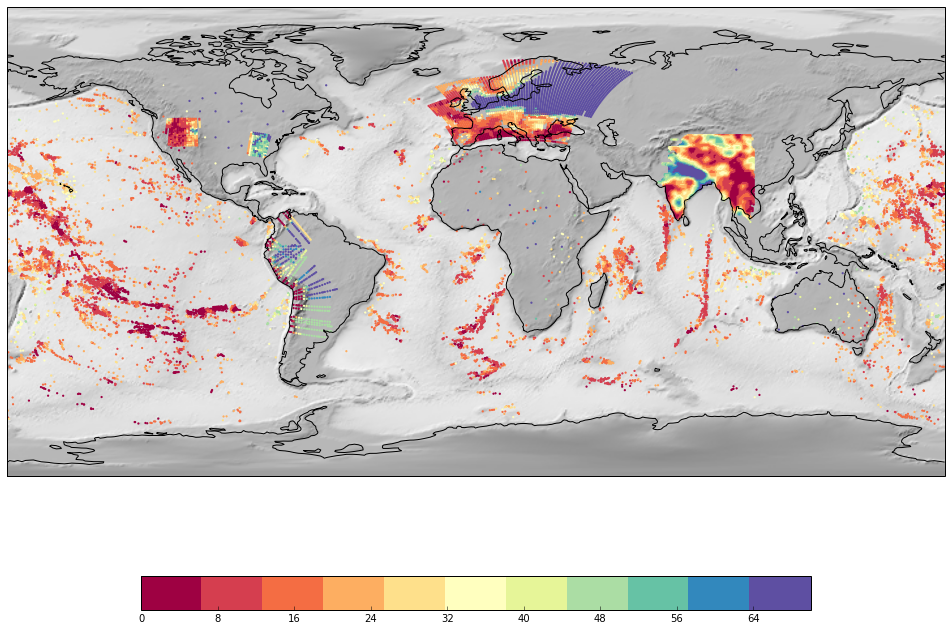

In [90]:
fig = plt.figure(figsize=(24,12), facecolor="none")
ax  = plt.subplot(111, projection=projection3)
ax.coastlines()
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

ax.imshow(hillshade, origin='upper', transform=base_projection, extent=global_extent, zorder=0)


colormap = plt.cm.get_cmap('Spectral', 11)
norm = colors.Normalize(vmin=0, vmax=200, clip=True)

m = ax.scatter(lons, lats, c=te, cmap=colormap, vmin=0, vmax=70, # , norm=norm,
               marker="o", s=5.0, transform=ccrs.Geodetic(), 
               linewidth=0.0, alpha=1.0)

fig.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
fig.show()

In [11]:
tegrid, tenorm, tecount  = weighted_average_to_nodes(lons, lats, te, interpolator )

nodes_to_refine = np.where(tenorm > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator)

print "Adding ", len(points[0]), " to triangulation (", interpolator.npts," )"

lonv2 = np.concatenate((interpolator.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

tegrid1x, tenorm1x, tecount1x  = weighted_average_to_nodes(lons, lats, te, interpolator1x )

nodes_to_refine = np.where(tenorm1x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator1x)

print "Adding ", len(points[0]), " to triangulation (", interpolator1x.npts," )"

lonv2 = np.concatenate((interpolator1x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator1x.lats, points[1]), axis=0)

interpolator2x = stripack.trmesh(lonv2, latv2)

tegrid2x, tenorm2x, tecount2x  = weighted_average_to_nodes(lons, lats, te, interpolator2x )


nodes_to_refine = np.where(tenorm2x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator2x)

print "Adding ", len(points[0]), " to triangulation (", interpolator2x.npts," )"

lonv2 = np.concatenate((interpolator2x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator2x.lats, points[1]), axis=0)

interpolator3x = stripack.trmesh(lonv2, latv2)

tegrid3x, tenorm3x, tecount3x  = weighted_average_to_nodes(lons, lats, te, interpolator3x )

nodes_to_refine = np.where(tenorm3x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator3x)

print "Adding ", len(points[0]), " to triangulation (", interpolator3x.npts," )"

lonv2 = np.concatenate((interpolator3x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator3x.lats, points[1]), axis=0)

interpolator4x = stripack.trmesh(lonv2, latv2)

tegrid4x, tenorm4x, tecount4x  = weighted_average_to_nodes(lons, lats, te, interpolator4x )


nodes_to_refine = np.where(tenorm4x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator4x)

print "Adding ", len(points[0]), " to triangulation (", interpolator4x.npts," )"

lonv2 = np.concatenate((interpolator4x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator4x.lats, points[1]), axis=0)

interpolator5x = stripack.trmesh(lonv2, latv2)

tegrid5x, tenorm5x, tecount5x  = weighted_average_to_nodes(lons, lats, te, interpolator5x )



Adding  1191  to triangulation ( 642  )
Adding  1884  to triangulation ( 1833  )
Adding  2213  to triangulation ( 3717  )
Adding  72  to triangulation ( 5930  )
Adding  5988  to triangulation ( 6002  )


In [83]:
ntri, triangles5x = interpolator5x.tri_list()

node_area = np.zeros(interpolator5x.npts)

for tri in triangles5x.T:
    tri_area = interpolator5x.tri_area(tri)
    node_area[tri-1] += 0.333 * tri_area
    
# This is a measure of accuracy based on the distance between nodes ...     
    
weight = np.log(1.0 / (node_area))
weight = weight / weight.max()
weight.min(), weight.max()

(0.3336767070680563, 1.0)

In [84]:
plot_interpolator = interpolator5x
plot_hfgrid = tegrid5x

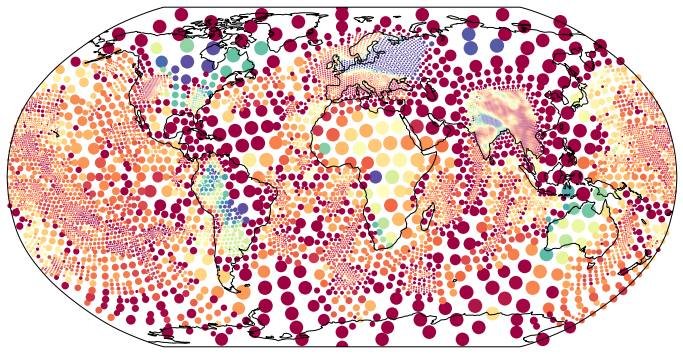

In [85]:
## Quick look to see what we got !


global_extent = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

plons = np.degrees(plot_interpolator.lons)
plats = np.degrees(plot_interpolator.lats)

ax.scatter(plons, plats, c=plot_hfgrid, cmap="Spectral", vmin=0.0, vmax=80.0,
            marker="o", s=10000*node_area, transform=ccrs.Geodetic(), linewidth=0.0)



In [93]:
gridlonv, gridlatv = np.meshgrid(np.linspace(-180,180,720), np.linspace(90,-90,360), sparse=False, indexing='xy')
gridlonv = gridlonv.reshape(-1)
gridlatv = gridlatv.reshape(-1)


In [94]:
interpolator = interpolator5x

hfllgrid = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), tegrid5x, order=1)
hfllnorm = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), weight, order=1)

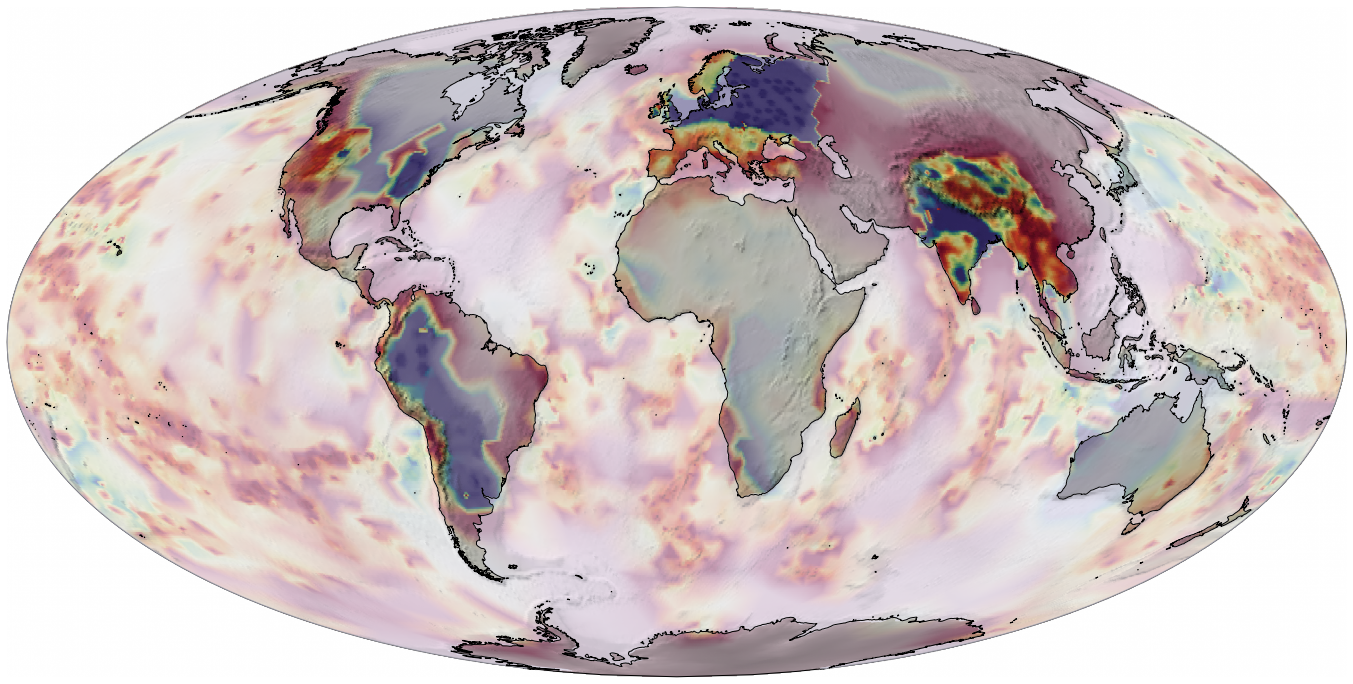

In [96]:
projection = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(24,12), facecolor="none", edgecolor="Black", frameon=True)
ax  = plt.subplot(111, projection=ccrs.Mollweide())

ax.coastlines(linewidth=2.0)
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

colormap = plt.cm.get_cmap('Spectral')
norm = colors.Normalize(vmin=0.0, vmax=50.0, clip=False)
col  = colormap(norm(hfllgrid))

## Now lighten the colors to represent areas with no coverage

alpha = 0.05 + 0.95 * ((hfllnorm-hfllnorm.min()) / (hfllnorm.max()-hfllnorm.min()))
# alpha = alpha**0.5

col[:,0] = alpha[:] * col[:,0] + (1.0-alpha[:])
col[:,1] = alpha[:] * col[:,1] + (1.0-alpha[:])
col[:,2] = alpha[:] * col[:,2] + (1.0-alpha[:])

# Apply hillshade image (works if gray cmap is used ... )

col2 = col.reshape(360,720,4)**2 * (0.0 + 1.0 * hillshade)

ax.imshow(col2, origin='upper', transform=base_projection,
          extent=global_extent, zorder=2,  
          interpolation="gaussian")



ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#EEEEFE")
ax.coastlines(resolution="50m", zorder=100)

# ????? 
# cb1 = colorbar.ColorbarBase(ax, cmap=colormap,
#                                 norm=norm,
#                                 orientation='horizontal')

# fig.savefig("ContinentalHeatFlow5x.png", dpi=600)
fig.show()

6.7587179827634465

256.0